### Соревнование. Регрессия

### Результат: Метрика 100< MSE < 200 

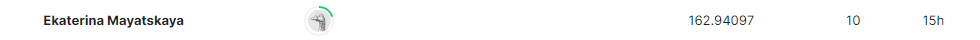

#### Описание датасета

- assessments.csv - Файл содержит информацию об оценках в модулях-презентациях. Обычно каждая презентация имеет ряд оценок, за которыми следует итоговый экзамен.

- courses.csv - Файл содержит список всех доступных модулей и их презентаций.

- studentInfo.csv - Файл содержит демографическую информацию об учащихся.

- studentRegistration.csv - Файл содержит информацию о времени регистрации студента на презентацию модуля.

- studentVle.csv - Фйал содержит информацию о взаимодействии каждого учащегося с материалами в VLE.

- vle.csv - Файл содержит информацию о доступных материалах в VLE (Virtual Learning Environment). Обычно это html-страницы, pdf-файлы и т. д.

Студенты имеют доступ к этим материалам в Интернете, и их взаимодействие с материалами записывается.

- Test_Who.csv - перечень id_student, code_modelu и code_presentation для тестовой выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Who.csv - перечень id_student, code_modelu и code_presentation для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Target_clf.csv - целевая метрика для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle, как в файле Train_Who.csv

- Submission_clf.csv - Пример файла для загрузки, в который проставлен всем незачет(кто знает может использовать для подгонки 👀). ID - внутренний идентификатор для оценки на Kaggle, как в файле Test_Who.csv

### Import библиотек

In [120]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

%matplotlib inline

### Скачиваем данные

In [121]:
# данные которые "все"
ass = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
# results = pd.read_csv('studentAssessment.csv')
info = pd.read_csv('studentInfo.csv')
reg = pd.read_csv('studentRegistration.csv')
studentVle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

In [122]:
ass.fillna(0)
courses.fillna(0)
info.fillna(0)
reg.fillna(0)
studentVle.fillna(0)
vle.fillna(0)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,0.0,0.0
1,546712,AAA,2013J,oucontent,0.0,0.0
2,546998,AAA,2013J,resource,0.0,0.0
3,546888,AAA,2013J,url,0.0,0.0
4,547035,AAA,2013J,resource,0.0,0.0
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,0.0,0.0
6360,897109,GGG,2014J,resource,0.0,0.0
6361,896965,GGG,2014J,oucontent,0.0,0.0
6362,897060,GGG,2014J,resource,0.0,0.0


#### Assessments info (информация об оценках)
- code_module – идентификационный код модуля, которому принадлежит оценка.
- code_presentation - идентификационный код презентации, к которой относится оценка.
- id_assessment – идентификационный номер оценки.
- assessment_type – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
- date – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
- weight - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [123]:
ass.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Проверим данные на пропуски

In [124]:
ass.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [125]:
ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [126]:
ass = ass.fillna(0)

#### Courses info (информация о курсах)
- code_module – кодовое имя модуля, которое служит идентификатором.
- code_presentation – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
- module_presentation_length - длина модуля-презентации в днях.

In [127]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [128]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [129]:
courses.isnull().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

#### Student registration (регистрация студентов)
- code_module – идентификационный код модуля.
- code_presentation - идентификационный код презентации.
- id_student – уникальный идентификационный номер студента.
- date_registration – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [130]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


In [131]:
reg.head()

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


In [132]:
reg.isnull().sum()

code_module           0
code_presentation     0
id_student            0
date_registration    45
dtype: int64

In [133]:
reg=reg.fillna(0)

#### VLE resources
- id_site - идентификационный номер материала.
- code_module – идентификационный код модуля.
- code_presentation - идентификационный код презентации.
- activity_type – роль, связанная с материалом модуля.
- week_from – неделя, с которой планируется использовать материал.
- week_to – неделя, до которой планируется использовать материал.

In [134]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [135]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [136]:
vle.isnull().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

In [137]:
vle = vle.fillna(0)

#### VLE Interactions
- code_module – идентификационный код модуля.
- code_presentation - идентификационный код представления модуля.
- id_student – уникальный идентификационный номер студента.
- id_site - идентификационный номер материала VLE.
- date – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
- sum_click – сколько раз учащийся взаимодействовал с материалом в этот день.

In [138]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [139]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [140]:
studentVle.isnull().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

#### Student information
- code_module – идентификационный код модуля, на котором зарегистрирован студент.
- code_presentation - идентификационный код презентации, во время которой студент регистрируется на модуле.
- id_student – уникальный идентификационный номер студента.
- gender – пол ученика.
- region – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
- highest_education – самый высокий уровень образования студента при поступлении на модульную презентацию.
- imd_band – задает диапазон Index of Multiple Depravation места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
- age_band – диапазон студенческого возраста.
- num_of_prev_attempts – количество раз, когда учащийся пытался пройти этот модуль.
- studied_credits – общее количество кредитов по модулям, которые студент изучает в настоящее время.
- disability – указывает, признан ли студент инвалидом.

In [141]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [142]:
info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


In [143]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [144]:
info.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
dtype: int64

In [145]:
info = info.fillna(0)

In [146]:
Train_Who = pd.read_csv('Train_Who.csv')
Test_Who = pd.read_csv('Test_Who.csv')

### Создадим из набора таблиц объединенный датасет

In [147]:
info

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N
...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N


In [148]:
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


#### Объединим info и courses ( информация о студенте и о курсах)

In [149]:
df1 = pd.merge(info, courses, on=['code_module', 'code_presentation'], how='inner')
df1

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,269
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,269
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,269
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,269


#### Добавим информацию о дате регистрации студента на курс

In [150]:
df2 = pd.merge(reg, df1, on=['code_module', 'code_presentation', 'id_student'], how='inner')
df2

,code_module,code_presentation,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,AAA,2013J,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
1,AAA,2013J,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268
2,AAA,2013J,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268
3,AAA,2013J,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268
4,AAA,2013J,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,269
32589,GGG,2014J,2645731,-23.0,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,269
32590,GGG,2014J,2648187,-129.0,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,269
32591,GGG,2014J,2679821,-49.0,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,269


#### Добавим информацию об оценках в модулях-презентациях (суммарная оценка по модулям)

Вес оценки по каждому курсу может иметь сильное влияние на конечный балл студента! Скорее всего это т признак может внести большой вклад в объяснение таргета

In [151]:
a = ass.groupby(['code_module','code_presentation']).agg(ass_weight = ('weight',sum)).reset_index()
a.head()

,code_module,code_presentation,ass_weight
0,AAA,2013J,200.0
1,AAA,2014J,200.0
2,BBB,2013B,200.0
3,BBB,2013J,200.0
4,BBB,2014B,200.0


In [152]:
df3 = pd.merge(a, df2, on=['code_module', 'code_presentation'], how='inner')
df3

,code_module,code_presentation,ass_weight,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,AAA,2013J,200.0,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
1,AAA,2013J,200.0,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268
2,AAA,2013J,200.0,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268
3,AAA,2013J,200.0,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268
4,AAA,2013J,200.0,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,100.0,2640965,-4.0,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,269
32589,GGG,2014J,100.0,2645731,-23.0,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,269
32590,GGG,2014J,100.0,2648187,-129.0,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,269
32591,GGG,2014J,100.0,2679821,-49.0,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,269


#### Добавим информацию о студентах по различным курсам

In [153]:
df_vle = studentVle.merge(vle, how='inner', on=['code_module', 'code_presentation', 'id_site'])
df_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,0.0,0.0
1,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
2,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
3,AAA,2013J,28400,546652,-10,8,forumng,0.0,0.0
4,AAA,2013J,30268,546652,-10,3,forumng,0.0,0.0


In [154]:
df_vle=df_vle.fillna(0)

In [155]:
df_vle

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,0.0,0.0
1,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
2,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
3,AAA,2013J,28400,546652,-10,8,forumng,0.0,0.0
4,AAA,2013J,30268,546652,-10,3,forumng,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10655275,GGG,2014J,647054,896969,227,8,oucontent,0.0,0.0
10655276,GGG,2014J,499187,896969,228,8,oucontent,0.0,0.0
10655277,GGG,2014J,629258,896969,228,23,oucontent,0.0,0.0
10655278,GGG,2014J,534672,896969,228,1,oucontent,0.0,0.0


#### Добавим информацию о длительности курсов и активности студентов по каждому курсу

Введем два признака:
- первый - среднее время взаимодействия студента с курсом 
- второй - сумма кликов по курсу ( активность студента)

Кажется, что эти признаки также могут внести вклад в объяснение таргета

In [156]:
b = df_vle.groupby(['code_module','code_presentation', 'id_student'])\
.agg(mean_date = ('date',np.mean), sum_date = ('date',sum), sum_click = ('sum_click',sum), mean_click = ('sum_click',np.mean)).reset_index()

In [157]:
b = b.fillna(0)
b.head()

,code_module,code_presentation,id_student,mean_date,sum_date,sum_click,mean_click
0,AAA,2013J,11391,102.132653,20018,934,4.765306
1,AAA,2013J,28400,86.993023,37407,1435,3.337209
2,AAA,2013J,30268,2.355263,179,281,3.697368
3,AAA,2013J,31604,106.147813,70376,2158,3.254902
4,AAA,2013J,32885,91.934659,32361,1034,2.937500


In [158]:
df4 = pd.merge(b,df3, how='inner', on=['code_module', 'code_presentation', 'id_student'])
df4.head()

,code_module,code_presentation,id_student,mean_date,sum_date,sum_click,mean_click,ass_weight,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,AAA,2013J,11391,102.132653,20018,934,4.765306,200.0,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
1,AAA,2013J,28400,86.993023,37407,1435,3.337209,200.0,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268
2,AAA,2013J,30268,2.355263,179,281,3.697368,200.0,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268
3,AAA,2013J,31604,106.147813,70376,2158,3.254902,200.0,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268
4,AAA,2013J,32885,91.934659,32361,1034,2.937500,200.0,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268


#### Посчитаем оценки по каждому модулю

In [159]:
df_asss = ass.groupby(by=['code_presentation','code_module'],as_index=False)[['id_assessment']].count()
df_asss.head()

,code_presentation,code_module,id_assessment
0,2013B,BBB,12
1,2013B,DDD,14
2,2013B,FFF,13
3,2013J,AAA,6
4,2013J,BBB,12


In [160]:
df5 = pd.merge(df_asss,df4, how='inner', on=['code_module', 'code_presentation'])
df5.head()

,code_presentation,code_module,id_assessment,id_student,mean_date,sum_date,sum_click,mean_click,ass_weight,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,2013B,BBB,12,23629,43.033898,2539,161,2.728814,200.0,-47.0,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,240
1,2013B,BBB,12,25107,120.149140,62838,2562,4.898662,200.0,-73.0,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,120,N,240
2,2013B,BBB,12,27891,36.701754,4184,301,2.640351,200.0,-58.0,M,Scotland,Lower Than A Level,0-10%,0-35,2,120,Y,240
3,2013B,BBB,12,29144,104.287574,88123,1914,2.265089,200.0,-24.0,M,South Region,Lower Than A Level,60-70%,0-35,0,120,N,240
4,2013B,BBB,12,31663,98.438961,151596,5906,3.835065,200.0,-60.0,M,North Region,A Level or Equivalent,30-40%,35-55,0,60,N,240


### Загрузим studentAssessment и создадим новые признаки

#### Assessments results (результаты оценки)
- id_assessment – идентификационный номер оценки.
- id_student –уникальный идентификационный номер студента.
- date_submitted – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
- is_banked – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации.


In [161]:
results = pd.read_csv('studentAssessment.csv')

In [162]:
results = results.fillna(0)

In [163]:
ass

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


#### Объединим два этих датасета 

In [164]:
res_ass = pd.merge(ass, results, on=['id_assessment'], how='inner')
res_ass

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0
...,...,...,...,...,...,...,...,...,...
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0


#### Создадим новый признак - время взаимодействия студента с курсом 

In [165]:
res_ass['data_res'] = res_ass['date'] - res_ass['date_submitted']

In [166]:
res_ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,data_res
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,1.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,-3.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,2.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,-7.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,0.0


#### Посчитаем суммарный/средний/медианный вес для каждого студента по каждому модулю

In [167]:
res_ass_weight = res_ass\
.groupby(['id_student', 'code_module', 'code_presentation'],as_index=False)\
.agg(total_weight=('weight', sum), median_weight = ('weight', np.median), mean_weight = ('weight', np.mean))

#### Посчитаем суммарное/средное/медианное время взаимодействия студента по каждому курсу 

In [168]:
res_ass_data = res_ass\
.groupby(['id_student', 'code_module', 'code_presentation'],as_index=False)\
.agg(total_data=('data_res', sum), median_data = ('data_res', np.median), mean_data = ('data_res', np.mean))

#### Объединим эти данные

In [169]:
res_ = pd.merge(res_ass_data, res_ass_weight, on=['id_student', 'code_module', 'code_presentation'], how='inner')
res_

,id_student,code_module,code_presentation,total_data,median_data,mean_data,total_weight,median_weight,mean_weight
0,6516,AAA,2014J,13.0,2.0,2.600000,100.0,20.0,20.000000
1,8462,DDD,2013J,1.0,2.0,0.333333,40.0,12.5,13.333333
2,8462,DDD,2014J,238.0,52.5,59.500000,50.0,10.0,12.500000
3,11391,AAA,2013J,9.0,2.0,1.800000,100.0,20.0,20.000000
4,23629,BBB,2013B,-14.0,-6.0,-3.500000,25.0,3.0,6.250000
...,...,...,...,...,...,...,...,...,...
25838,2698257,AAA,2013J,-10.0,0.0,-2.000000,100.0,20.0,20.000000
25839,2698535,CCC,2014B,-6.0,-2.0,-1.500000,39.0,7.5,9.750000
25840,2698535,EEE,2013J,-9.0,0.5,-2.250000,100.0,28.0,25.000000
25841,2698577,BBB,2014J,5.0,1.0,1.000000,100.0,20.0,20.000000


In [170]:
df6 = pd.merge(res_, df5, on=['code_presentation', 'code_module','id_student'], how='inner')
df6

,id_student,code_module,code_presentation,total_data,median_data,mean_data,total_weight,median_weight,mean_weight,id_assessment,...,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,6516,AAA,2014J,13.0,2.0,2.600000,100.0,20.0,20.000000,6,...,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,269
1,8462,DDD,2013J,1.0,2.0,0.333333,40.0,12.5,13.333333,7,...,-137.0,M,London Region,HE Qualification,30-40%,55<=,0,90,N,261
2,8462,DDD,2014J,238.0,52.5,59.500000,50.0,10.0,12.500000,7,...,-38.0,M,London Region,HE Qualification,30-40%,55<=,1,60,N,262
3,11391,AAA,2013J,9.0,2.0,1.800000,100.0,20.0,20.000000,6,...,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
4,23629,BBB,2013B,-14.0,-6.0,-3.500000,25.0,3.0,6.250000,12,...,-47.0,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25788,2698257,AAA,2013J,-10.0,0.0,-2.000000,100.0,20.0,20.000000,6,...,-58.0,M,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,268
25789,2698535,CCC,2014B,-6.0,-2.0,-1.500000,39.0,7.5,9.750000,10,...,-156.0,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,241
25790,2698535,EEE,2013J,-9.0,0.5,-2.250000,100.0,28.0,25.000000,5,...,-74.0,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,268
25791,2698577,BBB,2014J,5.0,1.0,1.000000,100.0,20.0,20.000000,6,...,16.0,F,Wales,Lower Than A Level,50-60%,35-55,0,60,N,262


#### Также посчитаем среднюю дату представления студентом

In [171]:
df_sub= results.groupby(by=['id_student'],as_index=False)[['date_submitted']].mean()
df_sub

,id_student,date_submitted
0,6516,111.600000
1,8462,23.000000
2,11391,112.400000
3,23629,55.750000
4,23698,133.444444
...,...,...
23364,2698251,121.428571
23365,2698257,116.200000
23366,2698535,90.375000
23367,2698577,106.200000


In [172]:
df7 = pd.merge(df_sub, df6, on=['id_student'], how='inner')
df7

,id_student,date_submitted,code_module,code_presentation,total_data,median_data,mean_data,total_weight,median_weight,mean_weight,...,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,6516,111.600,AAA,2014J,13.0,2.0,2.600000,100.0,20.0,20.000000,...,-52.0,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,269
1,8462,23.000,DDD,2013J,1.0,2.0,0.333333,40.0,12.5,13.333333,...,-137.0,M,London Region,HE Qualification,30-40%,55<=,0,90,N,261
2,8462,23.000,DDD,2014J,238.0,52.5,59.500000,50.0,10.0,12.500000,...,-38.0,M,London Region,HE Qualification,30-40%,55<=,1,60,N,262
3,11391,112.400,AAA,2013J,9.0,2.0,1.800000,100.0,20.0,20.000000,...,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
4,23629,55.750,BBB,2013B,-14.0,-6.0,-3.500000,25.0,3.0,6.250000,...,-47.0,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25788,2698257,116.200,AAA,2013J,-10.0,0.0,-2.000000,100.0,20.0,20.000000,...,-58.0,M,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,268
25789,2698535,90.375,CCC,2014B,-6.0,-2.0,-1.500000,39.0,7.5,9.750000,...,-156.0,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,241
25790,2698535,90.375,EEE,2013J,-9.0,0.5,-2.250000,100.0,28.0,25.000000,...,-74.0,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,268
25791,2698577,106.200,BBB,2014J,5.0,1.0,1.000000,100.0,20.0,20.000000,...,16.0,F,Wales,Lower Than A Level,50-60%,35-55,0,60,N,262


#### Объединим созданные датасеты с Train и Test

In [173]:
Train = pd.merge(Train_Who, df7, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train

,id_student,code_module,code_presentation,date_submitted,total_data,median_data,mean_data,total_weight,median_weight,mean_weight,...,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
ID,,,,,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,123.285714,4.0,1.0,0.571429,200.0,20.0,28.571429,...,-36.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,241.0
1,606593,DDD,2013J,55.333333,0.0,0.0,0.000000,40.0,12.5,13.333333,...,-32.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,261.0
2,1674799,CCC,2014J,135.500000,-297.0,-4.0,-37.125000,191.0,15.0,23.875000,...,-21.0,M,South Region,HE Qualification,70-80%,55<=,0.0,60.0,N,269.0
3,195246,FFF,2014J,107.181818,814.0,64.0,74.000000,75.0,0.0,6.818182,...,-124.0,M,West Midlands Region,Lower Than A Level,10-20,0-35,0.0,60.0,N,269.0
4,582080,FFF,2013J,19.000000,0.0,0.0,0.000000,12.5,12.5,12.500000,...,-114.0,M,South East Region,Lower Than A Level,10-20,35-55,0.0,60.0,N,268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,588477,AAA,2014J,112.800000,7.0,2.0,1.400000,100.0,20.0,20.000000,...,-141.0,M,Yorkshire Region,HE Qualification,20-30%,0-35,0.0,60.0,N,269.0
26070,653826,BBB,2014J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26071,126411,BBB,2013B,60.000000,-6.0,-6.0,-6.000000,1.0,1.0,1.000000,...,-124.0,F,West Midlands Region,Lower Than A Level,0-10%,0-35,2.0,60.0,Y,240.0


In [174]:
num=Train.isna().sum()
num

id_student                       0
code_module                      0
code_presentation                0
date_submitted                5471
total_data                    5471
median_data                   5471
mean_data                     5471
total_weight                  5471
median_weight                 5471
mean_weight                   5471
id_assessment                 5471
mean_date                     5471
sum_date                      5471
sum_click                     5471
mean_click                    5471
ass_weight                    5471
date_registration             5471
gender                        5471
region                        5471
highest_education             5471
imd_band                      5471
age_band                      5471
num_of_prev_attempts          5471
studied_credits               5471
disability                    5471
module_presentation_length    5471
dtype: int64

Заполним пропуски нулями

In [175]:
for i in range(len(num)):
    if num[i] != 0:
        Train[Train.columns[i]] = Train[Train.columns[i]].fillna(0)

In [176]:
Train.isna().sum()

id_student                    0
code_module                   0
code_presentation             0
date_submitted                0
total_data                    0
median_data                   0
mean_data                     0
total_weight                  0
median_weight                 0
mean_weight                   0
id_assessment                 0
mean_date                     0
sum_date                      0
sum_click                     0
mean_click                    0
ass_weight                    0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
module_presentation_length    0
dtype: int64

In [177]:
train_ind=Train.shape[0]

In [178]:
Test = pd.merge(Test_Who, df7, on=['id_student', 'code_module', 'code_presentation'], how='left')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test

,id_student,code_module,code_presentation,date_submitted,total_data,median_data,mean_data,total_weight,median_weight,mean_weight,...,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
ID,,,,,,,,,,,,,,,,,,,,,
26074,2588655,DDD,2014J,85.777778,-120.0,-1.0,-17.142857,200.0,25.00,28.571429,...,-92.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,262.0
26075,543628,CCC,2014B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26076,387276,BBB,2013B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26077,692219,CCC,2014J,21.000000,-3.0,-3.0,-3.000000,2.0,2.00,2.000000,...,-34.0,M,South Region,A Level or Equivalent,20-30%,0-35,0.0,90.0,N,269.0
26078,516212,BBB,2013J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,230510,DDD,2013J,41.500000,-5.0,-2.5,-2.500000,22.5,11.25,11.250000,...,-54.0,M,South Region,Lower Than A Level,10-20,0-35,0.0,60.0,Y,261.0
32589,384026,DDD,2013B,62.666667,-5.0,-2.0,-1.666667,16.0,3.00,5.333333,...,-34.0,F,Yorkshire Region,A Level or Equivalent,30-40%,0-35,1.0,120.0,N,240.0
32590,2367155,AAA,2013J,114.200000,0.0,0.0,0.000000,100.0,20.00,20.000000,...,-22.0,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0.0,120.0,N,268.0


In [179]:
num = Test.isna().sum()
num

id_student                       0
code_module                      0
code_presentation                0
date_submitted                1329
total_data                    1329
median_data                   1329
mean_data                     1329
total_weight                  1329
median_weight                 1329
mean_weight                   1329
id_assessment                 1329
mean_date                     1329
sum_date                      1329
sum_click                     1329
mean_click                    1329
ass_weight                    1329
date_registration             1329
gender                        1329
region                        1329
highest_education             1329
imd_band                      1329
age_band                      1329
num_of_prev_attempts          1329
studied_credits               1329
disability                    1329
module_presentation_length    1329
dtype: int64

Заполним пропуски нулями

In [180]:
for i in range(len(num)):
    if num[i] != 0:
        Test[Test.columns[i]] = Test[Test.columns[i]].fillna(0)

In [181]:
Target = pd.read_csv('Train_Target_reg.csv', index_col = 'ID')
Submission = pd.read_csv('Submission_reg.csv', index_col = 'ID')

#### Объединим тестовый и тренировочный датасеты для дальнейшей работы с ними

In [182]:
df = pd.concat([Train, Test])

In [183]:
df = df.merge(Target,on=['ID'], how='left')

In [184]:
df[:train_ind]

,id_student,code_module,code_presentation,date_submitted,total_data,median_data,mean_data,total_weight,median_weight,mean_weight,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,weighted_score
ID,,,,,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,123.285714,4.0,1.0,0.571429,200.0,20.0,28.571429,...,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,241.0,64.9125
1,606593,DDD,2013J,55.333333,0.0,0.0,0.000000,40.0,12.5,13.333333,...,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,261.0,14.8625
2,1674799,CCC,2014J,135.500000,-297.0,-4.0,-37.125000,191.0,15.0,23.875000,...,M,South Region,HE Qualification,70-80%,55<=,0.0,60.0,N,269.0,61.4300
3,195246,FFF,2014J,107.181818,814.0,64.0,74.000000,75.0,0.0,6.818182,...,M,West Midlands Region,Lower Than A Level,10-20,0-35,0.0,60.0,N,269.0,39.5000
4,582080,FFF,2013J,19.000000,0.0,0.0,0.000000,12.5,12.5,12.500000,...,M,South East Region,Lower Than A Level,10-20,35-55,0.0,60.0,N,268.0,9.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,588477,AAA,2014J,112.800000,7.0,2.0,1.400000,100.0,20.0,20.000000,...,M,Yorkshire Region,HE Qualification,20-30%,0-35,0.0,60.0,N,269.0,75.0000
26070,653826,BBB,2014J,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0.0,0.0,0,0.0,75.0000
26071,126411,BBB,2013B,60.000000,-6.0,-6.0,-6.000000,1.0,1.0,1.000000,...,F,West Midlands Region,Lower Than A Level,0-10%,0-35,2.0,60.0,Y,240.0,1.0000


#### Выведим числовые и категориальные признаки

In [185]:
num_columns=[]
cat_columns =[]
for i in df.columns:
    if df[i].dtype == np.float64 or df[i].dtype == np.int64 or df[i].dtype == np.int32:
        num_columns.append(i)
    else:
        cat_columns.append(i)

In [186]:
num_columns

['id_student',
 'date_submitted',
 'total_data',
 'median_data',
 'mean_data',
 'total_weight',
 'median_weight',
 'mean_weight',
 'id_assessment',
 'mean_date',
 'sum_date',
 'sum_click',
 'mean_click',
 'ass_weight',
 'date_registration',
 'num_of_prev_attempts',
 'studied_credits',
 'module_presentation_length',
 'weighted_score']

In [187]:
cat_columns

['code_module',
 'code_presentation',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability']

### Проведем Exploratory Data Analysis

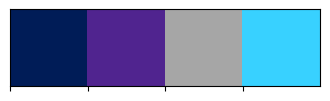

In [103]:
colors = ['#001c57','#50248f','#a6a6a6','#38d1ff']
sns.palplot(sns.color_palette(colors))

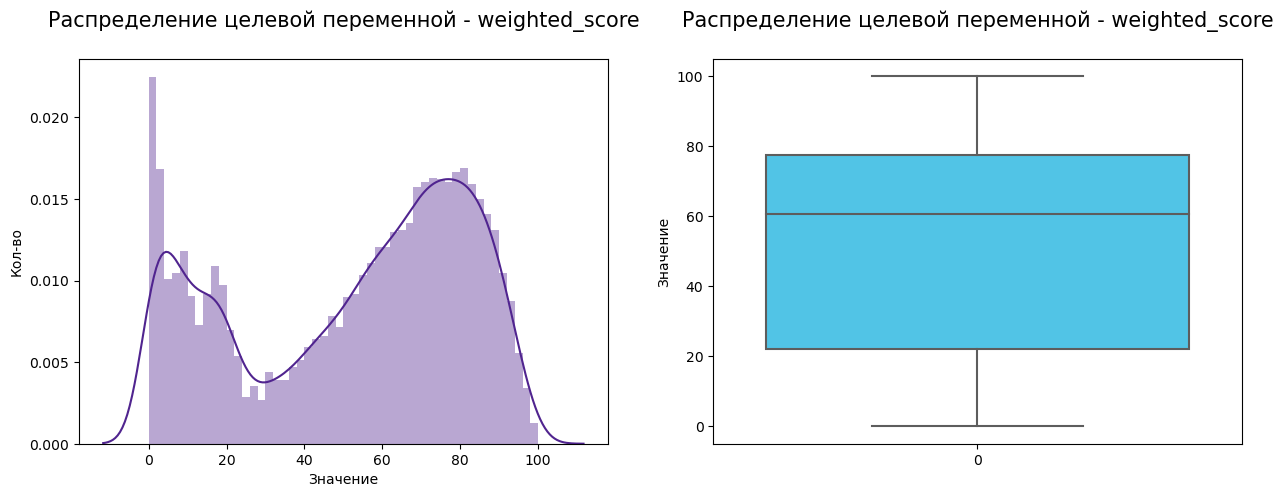

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(df.weighted_score.values, bins=50, color=colors[1])
plt.title('Распределение целевой переменной - weighted_score\n',fontsize=15)
plt.xlabel('Значение'); plt.ylabel('Кол-во');

plt.subplot(122)
sns.boxplot(df.weighted_score.values, color=colors[3])
plt.title('Распределение целевой переменной - weighted_score\n',fontsize=15)
plt.ylabel('Значение'); 

In [105]:
df.weighted_score.describe()

count    26074.000000
mean        52.495302
std         29.724236
min          0.000000
25%         22.000000
50%         60.500000
75%         77.400000
max        100.000000
Name: weighted_score, dtype: float64

Видно, что распредление имеет два пика, первый(левый) приходится на малые баллы(скорее всего ученик практически не занимался). Второй (правый) пик приходится на область больших баллов с максимумом - 80 баллов, что логично. Средний балл составил - 52ю Выбросов также не наблюдается

In [106]:
df_num =df[num_columns]

<Axes: >

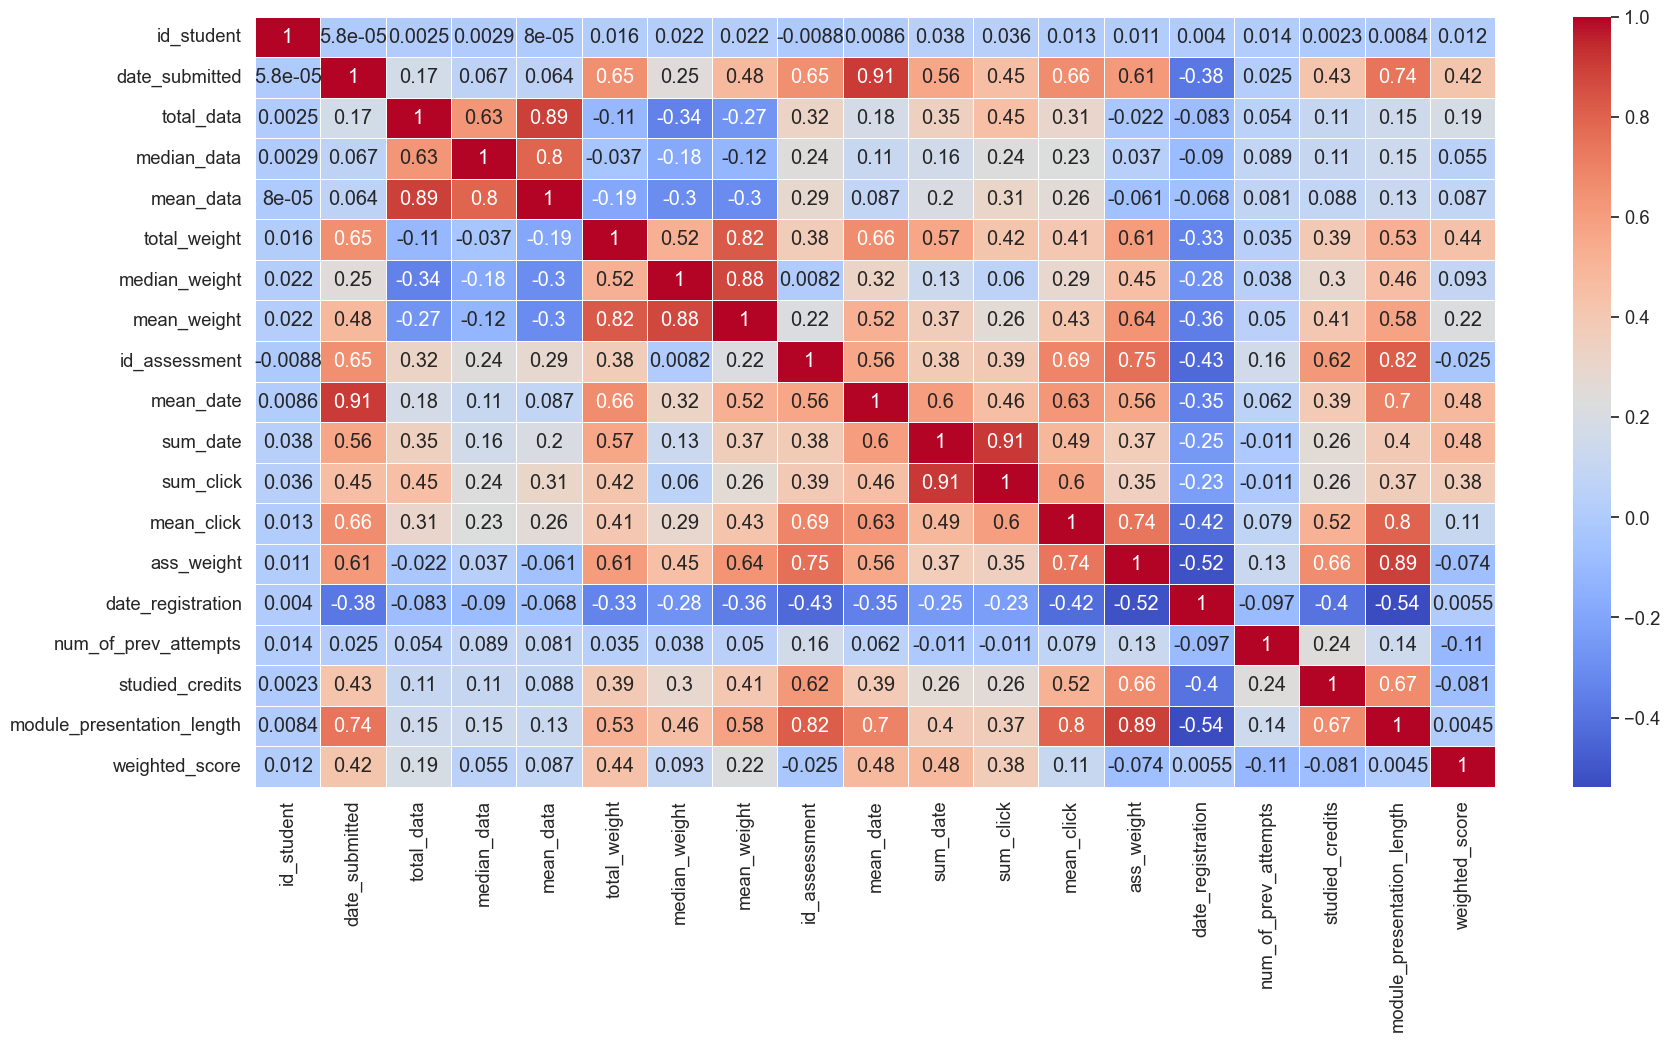

In [107]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
corr_matrix = df_num.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Видно, что есть признаки, которые сильно коррелируют с таргетом - наибольший вклад вносят признаки, которые мы создали -  mean_date, sum_date, sum_click, total_weight, date_submited

Также некоторые признки сильно коррелируют друг с другом, например, sum_click - mean_date - что логично, тк активность студента зависит от времени проведенным за выполнением курса, mean_date - module_presentation_lengh - аналогично длина всего курса, зависит от общего времени, который студент потратил на этот курс

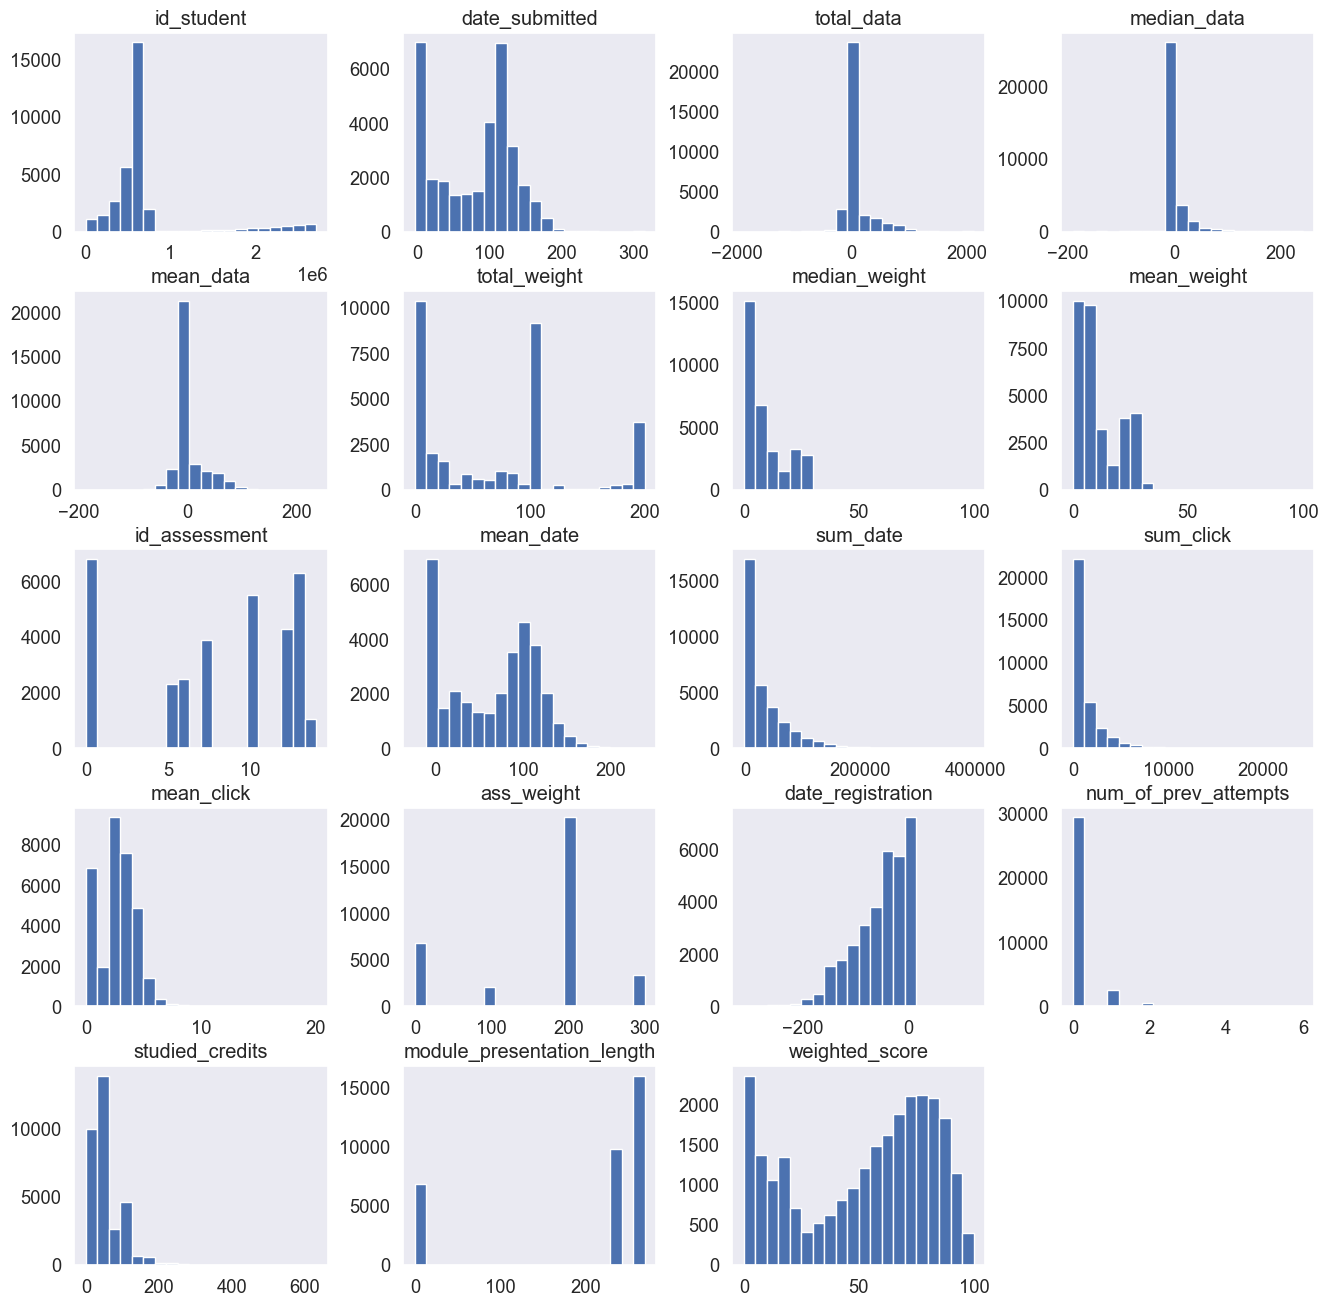

In [108]:
df_num.hist(figsize=(16, 16), bins=20, grid=False);

id_student - нужно удалить, так как он не несет никакой информации

#### Исследуем признаки 

Признак mean_date имеет два пика- первый приходится на студентов, которые практически не посищают курсы, второй- на тех кто их посещает

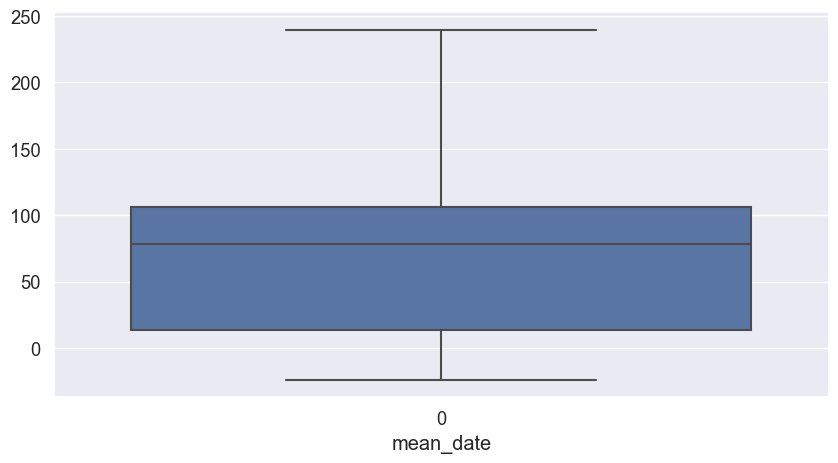

In [109]:
plt.figure(figsize=(10, 5))

sns.boxplot(df['mean_date'], whis=1.5)

plt.xlabel('mean_date')
plt.show()

Видно, что выбросов нет

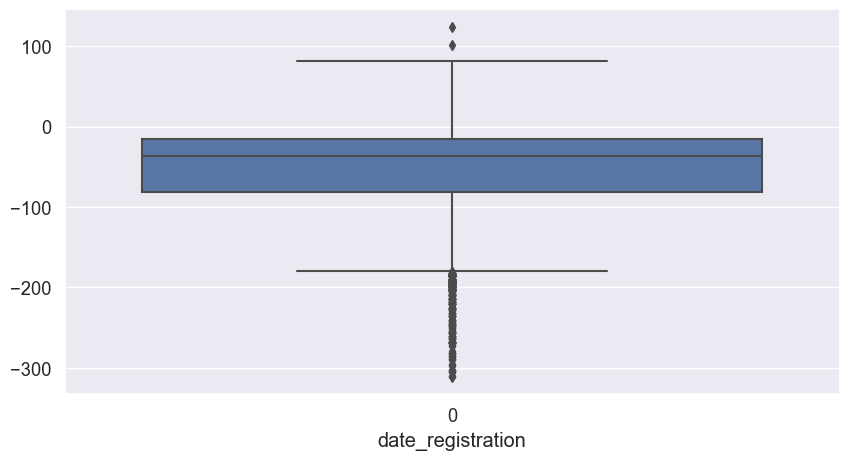

In [110]:
plt.figure(figsize=(10, 5))

sns.boxplot(df['date_registration'], whis=1.5)

plt.xlabel('date_registration')
plt.show()

Скорее всего значения выходящие за пределы интервала связаны с тем, что студенты могут регистрироваться на курс позже срока, или раньше срока, пока не будем удалять эти данные

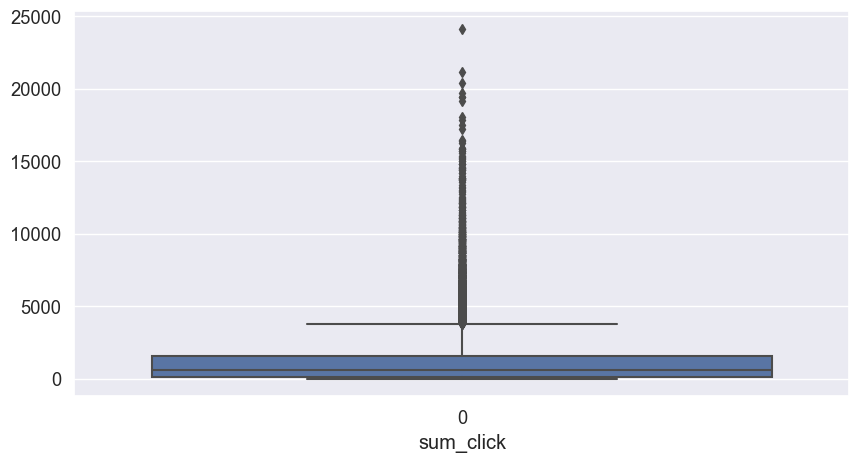

In [111]:
plt.figure(figsize=(10, 5))

sns.boxplot(df['sum_click'], whis=1.5)

plt.xlabel('sum_click')
plt.show()

Также эти значения вряд ли являются выбросами тк студент может делать сколько угодно кликов по страничке

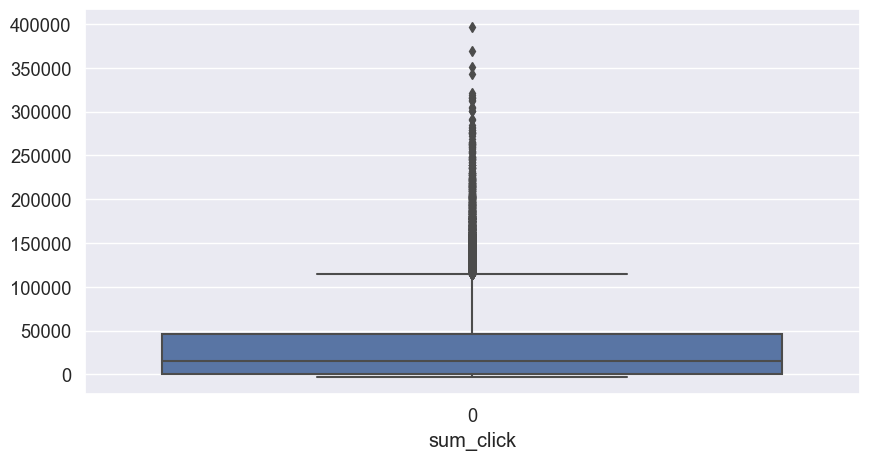

In [112]:
plt.figure(figsize=(10, 5))

sns.boxplot(df['sum_date'], whis=1.5)

plt.xlabel('sum_click')
plt.show()

Поскольку это суммарное время проведенное студентом за курсом - то это скорее всего не выбросы

#### Посмотрим на связь признаков друг с другом

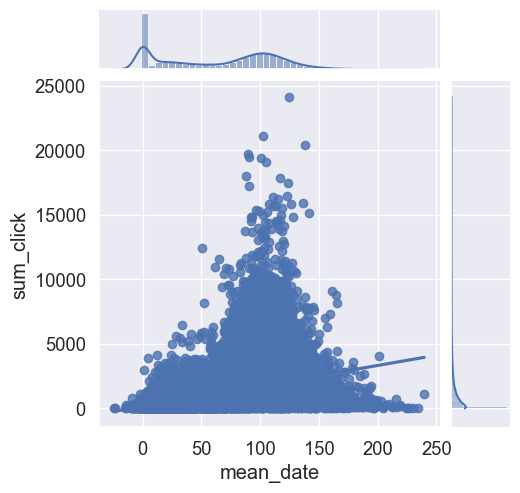

In [113]:
grid = sns.jointplot(x = df["mean_date"], y = df["sum_click"], data=df, kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

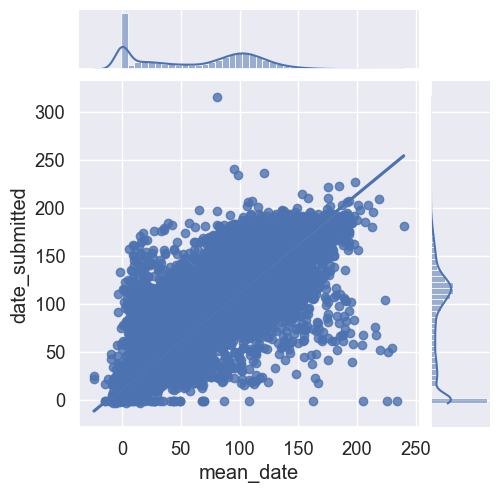

In [115]:
grid = sns.jointplot(x = df["mean_date"], y = df["date_submitted"], data=df, kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

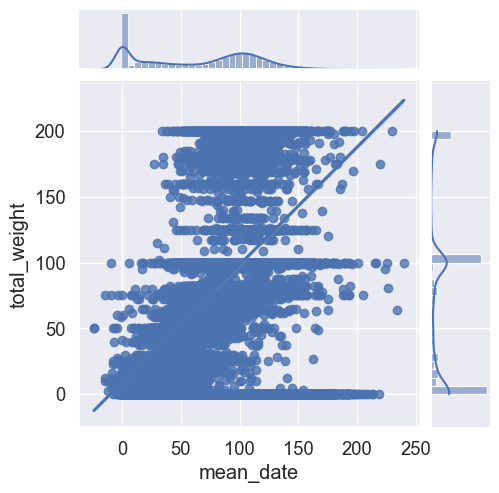

In [116]:
grid = sns.jointplot(x = df["mean_date"], y = df["total_weight"], data=df, kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

#### Оставим только информативные признаки (по нашему мнению)

In [188]:
num_columns=['date_submitted',
 'total_data',
 'median_data',
 'mean_data',
 'total_weight',
 'median_weight',
 'mean_weight',
 'id_assessment',
 'mean_date',
 'sum_date',
 'sum_click',
 'mean_click',
 'ass_weight',
 'date_registration',
 'num_of_prev_attempts',
 'studied_credits',
 'module_presentation_length']

In [189]:
cat_columns=['gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability']

In [192]:
# col = num_columns

In [191]:
col = cat_columns + num_columns

In [109]:
col

['gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'date_submitted',
 'total_data',
 'median_data',
 'mean_data',
 'total_weight',
 'median_weight',
 'mean_weight',
 'id_assessment',
 'mean_date',
 'sum_date',
 'sum_click',
 'mean_click',
 'ass_weight',
 'date_registration',
 'num_of_prev_attempts',
 'studied_credits',
 'module_presentation_length']

In [193]:
df = df[col]

In [194]:
from sklearn.model_selection import train_test_split

In [195]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

In [196]:
X = df.iloc[0:train_ind,:][col]
y = Target['weighted_score']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [198]:
from sklearn.ensemble import RandomForestRegressor

In [199]:
rf = RandomForestRegressor(max_depth=50, max_features=10, min_samples_leaf=3, min_samples_split=5, n_estimators=300)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features=10, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=300)

In [231]:
y_test_ens = rf.predict(X_test)

In [232]:
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_test_ens))
print('RMSE: %.1f' % mse(y_test,y_test_ens,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_test_ens))

Ошибка на тестовых данных
MSE: 203.4
RMSE: 14.3
R2 : 0.7722


Посмотрим как покажет себя xgboost

In [160]:
!pip install xgboost

In [202]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

In [203]:
model = XGBRegressor(learning_rate=0.1, max_depth=20, n_estimators=100)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [246]:
y_test_ens = model.predict(X_test)

In [235]:
# 20
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_test_ens))
print('RMSE: %.1f' % mse(y_test,y_test_ens,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_test_ens))

Ошибка на тестовых данных
MSE: 192.6
RMSE: 13.9
R2 : 0.7843


In [70]:
# model = CatBoostRegressor(loss_function="RMSE",iterations = 25000, learning_rate=0.1, verbose = 100,cat_features = cat_columns)
# model.fit(X= train_data, eval_set = eval_data)

0:	learn: 27.9373554	test: 28.0901286	best: 28.0901286 (0)	total: 80.8ms	remaining: 33m 39s
100:	learn: 16.2869251	test: 16.4855130	best: 16.4855130 (100)	total: 7.19s	remaining: 29m 32s
200:	learn: 16.0482419	test: 16.2416425	best: 16.2416425 (200)	total: 15.1s	remaining: 31m 4s
300:	learn: 15.9099871	test: 16.1086782	best: 16.1086782 (300)	total: 23.3s	remaining: 31m 50s
400:	learn: 15.8030550	test: 16.0092710	best: 16.0092710 (400)	total: 31.4s	remaining: 32m 4s
500:	learn: 15.7141332	test: 15.9313986	best: 15.9313983 (499)	total: 39.5s	remaining: 32m 12s
600:	learn: 15.6367298	test: 15.8684305	best: 15.8684285 (599)	total: 47.6s	remaining: 32m 14s
700:	learn: 15.5687170	test: 15.8070901	best: 15.8070901 (700)	total: 55.7s	remaining: 32m 11s
800:	learn: 15.5047306	test: 15.7525483	best: 15.7525483 (800)	total: 1m 3s	remaining: 32m 7s
900:	learn: 15.4488800	test: 15.7067483	best: 15.7067483 (900)	total: 1m 11s	remaining: 32m
1000:	learn: 15.3961232	test: 15.6644906	best: 15.6644906 (

8500:	learn: 13.9990011	test: 14.4690630	best: 14.4690630 (8500)	total: 13m 2s	remaining: 25m 17s
8600:	learn: 13.9918978	test: 14.4628162	best: 14.4628162 (8600)	total: 13m 11s	remaining: 25m 9s
8700:	learn: 13.9858057	test: 14.4578963	best: 14.4578963 (8700)	total: 13m 21s	remaining: 25m 1s
8800:	learn: 13.9774243	test: 14.4518581	best: 14.4518581 (8800)	total: 13m 31s	remaining: 24m 53s
8900:	learn: 13.9708102	test: 14.4447045	best: 14.4447045 (8900)	total: 13m 41s	remaining: 24m 45s
9000:	learn: 13.9643438	test: 14.4385298	best: 14.4385298 (9000)	total: 13m 51s	remaining: 24m 37s
9100:	learn: 13.9586821	test: 14.4339012	best: 14.4338883 (9099)	total: 14m	remaining: 24m 29s
9200:	learn: 13.9529786	test: 14.4288020	best: 14.4288020 (9200)	total: 14m 10s	remaining: 24m 20s
9300:	learn: 13.9477394	test: 14.4245550	best: 14.4245550 (9300)	total: 14m 20s	remaining: 24m 12s
9400:	learn: 13.9414808	test: 14.4199314	best: 14.4199314 (9400)	total: 14m 30s	remaining: 24m 4s
9500:	learn: 13.93

16700:	learn: 13.6911288	test: 14.1990713	best: 14.1990713 (16700)	total: 26m 22s	remaining: 13m 6s
16800:	learn: 13.6892732	test: 14.1972165	best: 14.1972165 (16800)	total: 26m 32s	remaining: 12m 57s
16900:	learn: 13.6869313	test: 14.1952476	best: 14.1952474 (16899)	total: 26m 42s	remaining: 12m 47s
17000:	learn: 13.6846773	test: 14.1938975	best: 14.1938975 (17000)	total: 26m 51s	remaining: 12m 38s
17100:	learn: 13.6829029	test: 14.1916306	best: 14.1916302 (17099)	total: 27m 1s	remaining: 12m 29s
17200:	learn: 13.6810537	test: 14.1896178	best: 14.1896178 (17200)	total: 27m 11s	remaining: 12m 19s
17300:	learn: 13.6794638	test: 14.1880169	best: 14.1880169 (17300)	total: 27m 21s	remaining: 12m 10s
17400:	learn: 13.6777886	test: 14.1862989	best: 14.1862909 (17399)	total: 27m 31s	remaining: 12m 1s
17500:	learn: 13.6761182	test: 14.1846699	best: 14.1846693 (17499)	total: 27m 41s	remaining: 11m 51s
17600:	learn: 13.6742421	test: 14.1829329	best: 14.1829329 (17600)	total: 27m 51s	remaining: 1

24999:	learn: 13.5707275	test: 14.1063186	best: 14.1063186 (24999)	total: 39m 41s	remaining: 0us

bestTest = 14.10631861
bestIteration = 24999



In [200]:
X_test_ = df.iloc[train_ind:,:][col]

In [204]:
y_pred = model.predict(X_test_)

In [205]:
Submission['weighted_score'] = y_pred

In [206]:
Submission.to_csv('My_Submission_new25000.csv',index=True)

### Важность признаков

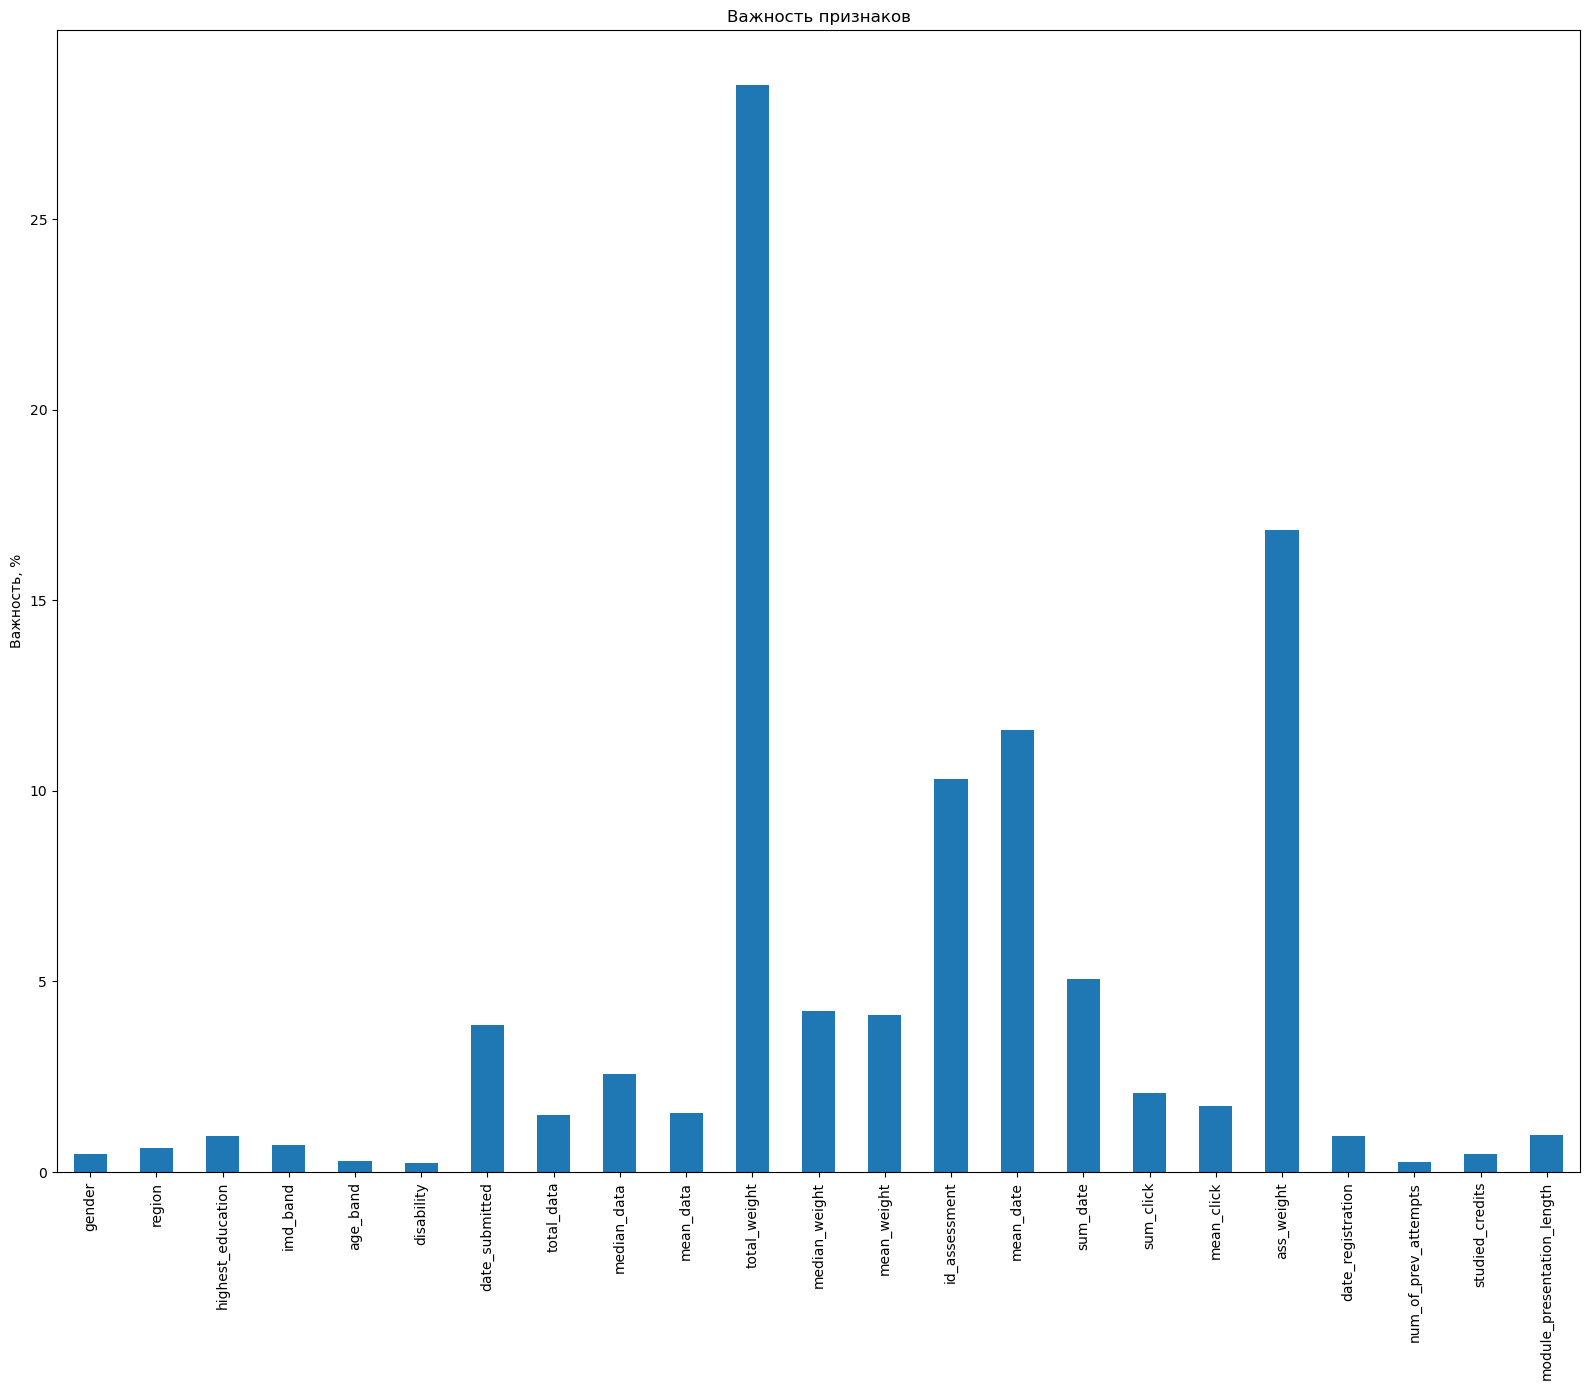

In [65]:
cat_ = pd.Series(model.get_feature_importance(),
                         col)
fig, ax = plt.subplots(figsize=(16,14))
cat_.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()